In [178]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import sys
import timeit

# problem 1

In [179]:
df = pd.read_csv('DailyReturn.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.iloc[::-1].reset_index(inplace=True) # flip the dataset to make the most recent first row

In [180]:
n = df.shape[0]
x = pd.Series(range(n)) + 1
weight = pd.Series(np.zeros(n))
cum_weight = pd.Series(np.zeros(n))

In [181]:
def polulate_weights(w, cw, lamda):
    tw = 0
    for i in range(n):
        w[i] = (1 - lamda) * lamda ** i
        tw += w[i]
        cw[i] = tw
    for i in range(n):
        w[i] /= tw
        cw[i] /= tw
    return w, cw

In [182]:
def get_weighted_cov(x, y, w):
    result = 0.
    for i in range(w.size):
        result += (x[i] - x.mean()) * (y[i] - y.mean()) * w[i]
    return result

def populate_exp_weighted_cov_matrix(w, data):
    variable = data.shape[1]
    result = np.zeros((variable, variable))
    for i in range(variable):
        for j in range(variable):
            result[i][j] = get_weighted_cov(data.iloc[:, i], data.iloc[:, j], w)
    return result

In [183]:
def conduct_pca(mat):
    eigenvalues, eigenvectors = np.linalg.eigh(mat)
    e_vals_sort = np.flip(np.real(eigenvalues), axis=0)
    pos_e_vals = e_vals_sort[e_vals_sort >= 1e-8]
    pos_e_vecs = np.flip(np.real(eigenvectors), axis=1)[:, : pos_e_vals.size]
    cum_explain = [pos_e_vals[:i+1].sum() / pos_e_vals.sum() for i in range(pos_e_vals.size)]
    return pos_e_vals, pos_e_vecs, cum_explain

In [184]:
def plot_result_problem1(lamda):
    w1, cw1 = polulate_weights(weight, cum_weight, lamda)
    cov_mat1 = populate_exp_weighted_cov_matrix(w1, df)
    cum_var_ex = conduct_pca(cov_mat1)[2]
    fig = plt.figure()
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    ax1.plot(x, w1, 'c*-', linewidth=1)
    ax2.plot(x, cw1, 'm*-', linewidth=1)
    ax1.set_title('exponential weights for λ={:.2f}'.format(lamda))
    ax2.set_title('cumulative weights for λ={:.2f}'.format(lamda))
    plt.show()
    return cum_var_ex

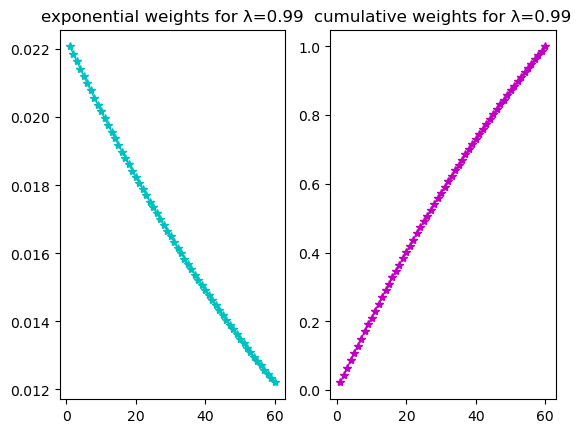

number of positive eigenvalues 59


In [211]:
# λ=0.99
cum_var_ex1 = plot_result_problem1(0.99)
print("number of positive eigenvalues", len(cum_var_ex1))

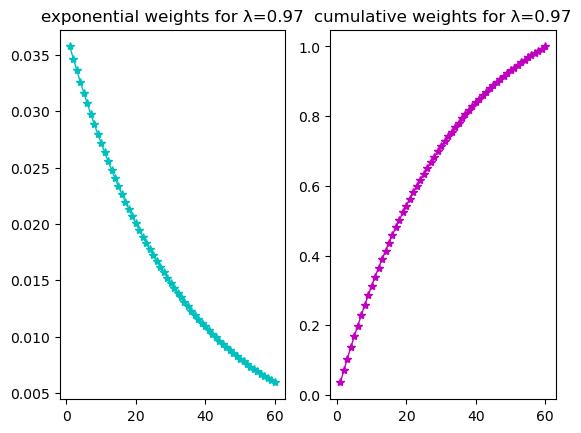

number of positive eigenvalues 59


In [212]:
# λ=0.97
cum_var_ex2 = plot_result_problem1(0.97)
print("number of positive eigenvalues", len(cum_var_ex2))

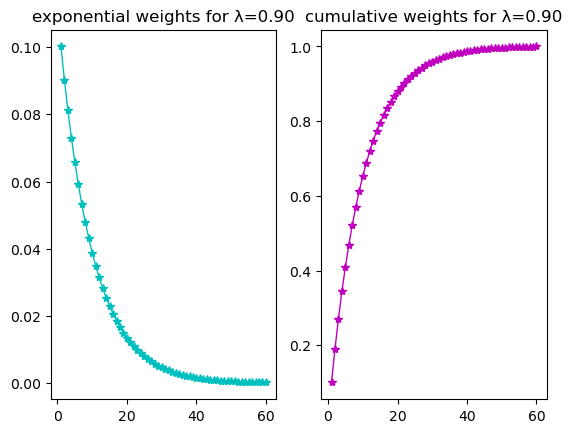

number of positive eigenvalues 59


In [213]:
# λ=0.90
cum_var_ex3 = plot_result_problem1(0.90)
print("number of positive eigenvalues", len(cum_var_ex3))

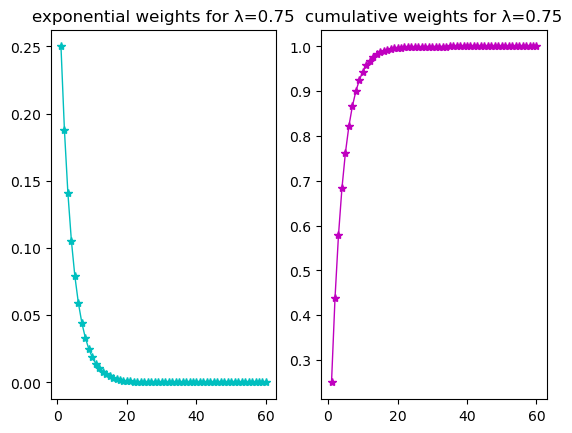

number of positive eigenvalues 42


In [214]:
# λ=0.75
cum_var_ex4 = plot_result_problem1(0.75)
print("number of positive eigenvalues", len(cum_var_ex4))

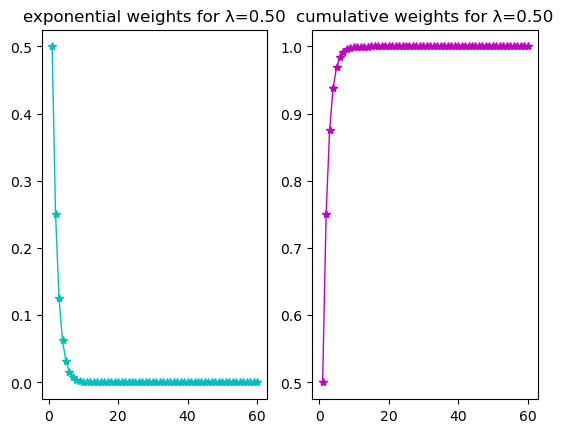

number of positive eigenvalues 20


In [215]:
# λ=0.5
cum_var_ex5 = plot_result_problem1(0.5)
print("number of positive eigenvalues", len(cum_var_ex5))

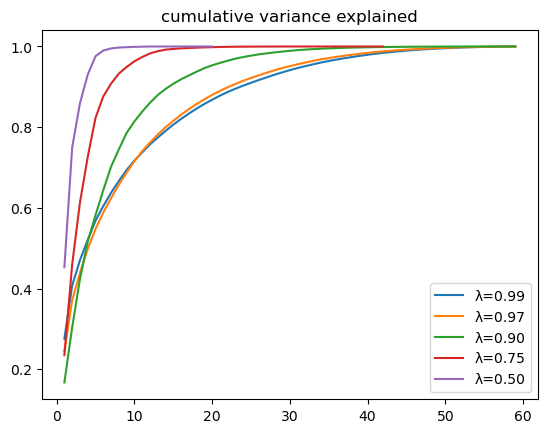

In [209]:
fig, ax = plt.subplots()
ax.plot(range(1, len(cum_var_ex1)+1), cum_var_ex1, label='λ=0.99')
ax.plot(range(1, len(cum_var_ex2)+1), cum_var_ex2, label='λ=0.97')
ax.plot(range(1, len(cum_var_ex3)+1), cum_var_ex3, label='λ=0.90')
ax.plot(range(1, len(cum_var_ex4)+1), cum_var_ex4, label='λ=0.75')
ax.plot(range(1, len(cum_var_ex5)+1), cum_var_ex5, label='λ=0.50')
ax.set_title('cumulative variance explained')
ax.legend()
plt.show()

# problem 2

In [190]:
def chol_psd(mat):
    number = mat.shape[0]
    root = np.zeros((number, number))
    for j in range(number):
        s = 0.
        if j > 0:
            s = root[j, :j]@root[j, :j].T
        temp = mat[j, j] - s
        if -1e-8 <= temp <= 0:
            temp = 0.
        root[j, j] = math.sqrt(temp)

        if root[j, j] == 0:
            root[j:n, j] = 0.
        else:
            for i in range(j+1, number):
                s = root[i, :j]@root[j, :j].T
                root[i, j] = (mat[i, j] - s) / root[j, j]
    return root

In [191]:
def near_psd(mat, epsilon=0.0):
    number = mat.shape[0]
    invSD = None
    result = mat.copy()

    #calculate the correlation matrix if we got a covariance
    if np.diagonal(result).sum() != number:
        invSD = np.diag(np.sqrt(np.diagonal(result))**(-1))
        result = invSD@result@invSD

    vals, vecs = np.linalg.eigh(result)
    vals = np.maximum(vals, np.ones(vals.shape)*epsilon)
    T = (vecs*vecs@vals)**(-1)
    T = np.diag(np.sqrt(T))
    l = np.diag(np.sqrt(vals))
    B = T@vecs@l
    result = B@B.T

    #Add back the variance
    if invSD != None:
        invSD = np.diag(np.diagonal(invSD)**(-1))
        result = invSD@result@invSD

    return result

In [192]:
def weighted_f_norm(A, W):
    WAW = np.diag(np.sqrt(W))@A@np.diag(np.sqrt(W))
    return np.linalg.norm(WAW)**(2)

In [193]:
def first_projection(A):
    PuA = A.copy()
    for i in range(PuA.shape[0]):
        PuA[i, i] = 1.
    return PuA

def second_projection(A, W):
    WAW = np.diag(np.sqrt(W))@A@np.diag(np.sqrt(W))
    vals, vecs = np.linalg.eigh(WAW)
    vals = np.maximum(vals, np.zeros(vals.shape))
    PsA = np.diag(np.sqrt(W)**(-1))@(vecs@np.diag(vals)@vecs.T)@np.diag(np.sqrt(W)**(-1))
    return PsA

def higham(A, W=None, max_iteration=100):
    if W == None:
        W = np.ones(A.shape[0])
    dif_S = np.zeros(A.shape)
    last_gama = sys.float_info.max

    #calculate the correlation matrix if we got a covariance
    invSD = None
    if np.diagonal(A).sum() != A.shape[0]:
        invSD = np.diag(np.sqrt(np.diagonal(A))**(-1))
        A = invSD@A@invSD

    Y = A.copy()

    for i in range(max_iteration):
        R = Y - dif_S # move back a little
        X = second_projection(R, W)
        dif_S = X - R
        Y = first_projection(X)
        cur_gama = weighted_f_norm(Y - A, W)
        evals = np.linalg.eigh(Y)[0]
        if abs(cur_gama - last_gama) <= 1e-9 and evals[0] >= -1e-8:
            break
        last_gama = cur_gama

    #Add back the variance
    if invSD != None:
        invSD = np.diag(np.diagonal(invSD)**(-1))
        Y = invSD@Y@invSD

    return Y

In [194]:
# For non-psd matrix 500x500
num = 500
sigma = np.ones((num, num))*0.9
for i in range(num):
    sigma[i, i] = 1.
sigma[0, 1] = 0.7357
sigma[1, 0] = 0.7357

In [195]:
start = timeit.default_timer()
fixed_near = near_psd(sigma)
end = timeit.default_timer()
print("run time for near psd, N=500: {:.6f}s".format(end - start))
if np.flip(np.linalg.eigh(fixed_near)[0])[-1] >= -1e-8:
    print("the matrix is now PSD")
else:
    print("the matrix is still non-PSD")

run time for near psd, N=500: 0.073873s
the matrix is now PSD


In [196]:
start = timeit.default_timer()
fixed_hig = higham(sigma)
end = timeit.default_timer()
print("run time for higham, N=500: {:.6f}s".format(end - start))
if np.flip(np.linalg.eigh(fixed_hig)[0])[-1] >= -1e-8:
    print("the matrix is now PSD")
else:
    print("the matrix is still non-PSD")

run time for higham, N=500: 3.391604s
the matrix is now PSD


In [197]:
f_norm_near = weighted_f_norm(fixed_near - sigma, np.ones(num))
f_norm_hig = weighted_f_norm(fixed_hig - sigma, np.ones(num))
print("Frobenius norm for near psd, N=500: ", f_norm_near)
print("Frobenius norm for higham, N=500: ", f_norm_hig)

Frobenius norm for near psd, N=500:  0.3937846834984189
Frobenius norm for higham, N=500:  0.008036762460405486


In [198]:
#increase N to compare run time and f norm
num = 1000
sigma = np.ones((num, num))*0.9
for i in range(num):
    sigma[i, i] = 1.
sigma[0, 1] = 0.7357
sigma[1, 0] = 0.7357

start = timeit.default_timer()
fixed_near = near_psd(sigma)
end = timeit.default_timer()
print("run time for near psd, N=1000: {:.6f}s".format(end - start))

start = timeit.default_timer()
fixed_hig = higham(sigma)
end = timeit.default_timer()
print("run time for higham, N=1000: {:.6f}s".format(end - start))

f_norm_near = weighted_f_norm(fixed_near - sigma, np.ones(num))
f_norm_hig = weighted_f_norm(fixed_hig - sigma, np.ones(num))
print("Frobenius norm for near psd, N=1000: ", f_norm_near)
print("Frobenius norm for higham, N=1000: ", f_norm_hig)

run time for near psd, N=1000: 0.218971s
run time for higham, N=1000: 11.374759s
Frobenius norm for near psd, N=1000:  0.7929738934490357
Frobenius norm for higham, N=1000:  0.008152132757171186


In [199]:
num = 2000
sigma = np.ones((num, num))*0.9
for i in range(num):
    sigma[i, i] = 1.
sigma[0, 1] = 0.7357
sigma[1, 0] = 0.7357

start = timeit.default_timer()
fixed_near = near_psd(sigma)
end = timeit.default_timer()
print("run time for near psd, N=2000: {:.6f}s".format(end - start))

start = timeit.default_timer()
fixed_hig = higham(sigma)
end = timeit.default_timer()
print("run time for higham, N=2000: {:.6f}s".format(end - start))

f_norm_near = weighted_f_norm(fixed_near - sigma, np.ones(num))
f_norm_hig = weighted_f_norm(fixed_hig - sigma, np.ones(num))
print("Frobenius norm for near psd, N=2000: ", f_norm_near)
print("Frobenius norm for higham, N=2000: ", f_norm_hig)

run time for near psd, N=2000: 1.183893s
run time for higham, N=2000: 75.132616s
Frobenius norm for near psd, N=2000:  1.5913479056271598
Frobenius norm for higham, N=2000:  0.008210369989178741


# problem 3

In [200]:
# mat1: normal covariance matrix
n_cov = np.array(df.cov())

# mat2: exponentially weighted covariance matrix
weight = pd.Series(np.zeros(n))
cum_weight = pd.Series(np.zeros(n))
w = polulate_weights(weight, cum_weight, 0.97)[0]
ew_cov = populate_exp_weighted_cov_matrix(w, df)

In [201]:
# mat3: pearson correlation + exponentially weighted variance
ew_std_div = np.diag(np.sqrt(np.diagonal(ew_cov))) # diagonal matrix
cor_ew_var = np.array(ew_std_div@df.corr()@ew_std_div)

# mat4: exponentially weighted correlation + variance
std_div = np.diag(np.sqrt(np.diagonal(n_cov)))
d1 = np.diag(np.sqrt(np.diagonal(ew_cov))**(-1))
ew_cor = d1@ew_cov@d1
ew_cor_var = std_div@ew_cor@std_div

In [202]:
def direct_simulation(mat):
    start = timeit.default_timer()
    L = chol_psd(mat)
    Z = np.random.standard_normal((L.shape[0], 25000))
    X = (L@Z).T
    end = timeit.default_timer()
    new_cov = np.cov(X.T)
    f_norm = weighted_f_norm(new_cov - mat, np.ones(new_cov.shape[0]))
    print("For direct simulation:")
    print("Frobenius norm is: {:.10f}".format(f_norm))
    print("Run time is: {:.6f}".format(end - start))

In [203]:
def simulation_with_pca(mat, min_explain=1.0):
    start = timeit.default_timer()
    pca = conduct_pca(mat)
    pca_vals = pca[0]
    pca_vecs = pca[1]
    for i, cum in enumerate(pca[2]):
        if cum >= min_explain:
            pca_vals = pca_vals[: i+1]
            pca_vecs = pca_vecs[:, : i+1]
    B = pca_vecs@np.diag(np.sqrt(pca_vals))
    r = np.random.standard_normal((B.shape[1], 25000))
    X = (B@r).T
    end = timeit.default_timer()
    new_cov = np.cov(X.T)
    f_norm = weighted_f_norm(new_cov - mat, np.ones(new_cov.shape[0]))
    print("For pca with {:.2f}% explained:".format(min_explain * 100))
    print("Frobenius norm is: {:.10f}".format(f_norm))
    print("Run time is: {:.6f}".format(end - start))

In [204]:
print("For matrix 1: normal covariance")
direct_simulation(n_cov)
simulation_with_pca(n_cov)
simulation_with_pca(n_cov, 0.75)
simulation_with_pca(n_cov, 0.5)

For matrix 1: normal covariance
For direct simulation:
Frobenius norm is: 0.0000000649
Run time is: 0.046350
For pca with 100.00% explained:
Frobenius norm is: 0.0000000746
Run time is: 0.030961
For pca with 75.00% explained:
Frobenius norm is: 0.0000026809
Run time is: 0.017960
For pca with 50.00% explained:
Frobenius norm is: 0.0000111436
Run time is: 0.010261


In [205]:
print("For matrix 2: exponentially weighted covariance")
direct_simulation(ew_cov)
simulation_with_pca(ew_cov)
simulation_with_pca(ew_cov, 0.75)
simulation_with_pca(ew_cov, 0.5)

For matrix 2: exponentially weighted covariance
For direct simulation:
Frobenius norm is: 0.0000000422
Run time is: 0.048518
For pca with 100.00% explained:
Frobenius norm is: 0.0000000463
Run time is: 0.031333
For pca with 75.00% explained:
Frobenius norm is: 0.0000028235
Run time is: 0.014035
For pca with 50.00% explained:
Frobenius norm is: 0.0000104645
Run time is: 0.011131


In [206]:
print("For matrix 3: pearson correlation + exponentially weighted variance")
direct_simulation(cor_ew_var)
simulation_with_pca(cor_ew_var)
simulation_with_pca(cor_ew_var, 0.75)
simulation_with_pca(cor_ew_var, 0.5)

For matrix 3: pearson correlation + exponentially weighted variance
For direct simulation:
Frobenius norm is: 0.0000000505
Run time is: 0.047865
For pca with 100.00% explained:
Frobenius norm is: 0.0000000451
Run time is: 0.033239
For pca with 75.00% explained:
Frobenius norm is: 0.0000025509
Run time is: 0.013882
For pca with 50.00% explained:
Frobenius norm is: 0.0000108957
Run time is: 0.009741


In [207]:
print("For matrix 4: exponentially weighted correlation + variance")
direct_simulation(ew_cor_var)
simulation_with_pca(ew_cor_var)
simulation_with_pca(ew_cor_var, 0.75)
simulation_with_pca(ew_cor_var, 0.5)

For matrix 4: exponentially weighted correlation + variance
For direct simulation:
Frobenius norm is: 0.0000000461
Run time is: 0.046816
For pca with 100.00% explained:
Frobenius norm is: 0.0000000474
Run time is: 0.032252
For pca with 75.00% explained:
Frobenius norm is: 0.0000030966
Run time is: 0.015244
For pca with 50.00% explained:
Frobenius norm is: 0.0000134805
Run time is: 0.012132
